# Azure AI Agent service - Code interpreter

<img src="https://learn.microsoft.com/en-us/azure/ai-services/agents/media/agent-service-the-glue.png" width=800>

> https://learn.microsoft.com/en-us/azure/ai-services/agents/

In [1]:
import glob
import json
import ipyplot
import matplotlib.pyplot as plt
import os
import sys
import time

from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from azure.ai.projects.models import CodeInterpreterTool, FilePurpose
from dotenv import load_dotenv
from openai import AzureOpenAI
from PIL import Image

In [2]:
load_dotenv("azure.env")

True

In [3]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [4]:
IMAGES_DIR = "images"

os.makedirs(IMAGES_DIR, exist_ok=True)

In [5]:
HOME_DIR = os.getcwd()

## Project

In [6]:
project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.getenv("PROJECT_CONNECTION_STRING"),
)

## Examples

In [7]:
DOCUMENTS_DIR = "data"

os.makedirs(DOCUMENTS_DIR, exist_ok=True)

output_file = os.path.join(DOCUMENTS_DIR, "titanic.csv")

In [8]:
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv -O $output_file

--2025-05-20 13:03:42--  https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘data/titanic.csv’

data/titanic.csv    100%[===================>]  58.89K  --.-KB/s    in 0.001s  

2025-05-20 13:03:43 (43.7 MB/s) - ‘data/titanic.csv’ saved [60302/60302]



In [9]:
model = "gpt-4o-mini"

In [10]:
file = project_client.agents.upload_file_and_poll(file_path=output_file,
                                                  purpose=FilePurpose.AGENTS)

print(f"Uploaded file, file ID: {file.id}")

Uploaded file, file ID: assistant-RBH6Pm5L773FFcZjSLTvcq


In [11]:
code_interpreter = CodeInterpreterTool(file_ids=[file.id])

# Create agent with code interpreter tool and tools_resources
agent = project_client.agents.create_agent(
    model=model,
    name="Agent with code interpreter",
    instructions="You are a helpful AI agent that can analyse input file for statistics",
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)

## Example

In [12]:
prompt = "Plot a correlation matrix using the blues theme"

In [13]:
# create a thread
thread = project_client.agents.create_thread()
print(f"Created thread, thread ID: {thread.id}")

# create a message
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

run = project_client.agents.create_and_process_run(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

if run.status == "failed":
    print(f"Run failed: {run.last_error}")

# print the messages from the agent
messages = project_client.agents.list_messages(thread_id=thread.id)

Created thread, thread ID: thread_JEzAPtB4YkGig5WTMO5vVbY1
Created message, message ID: msg_skBMLmXKVLBJsHTBrTBLtoMO
Created run, run ID: run_fsYTtM8wvKtO2M9XhsaheV3h


In [14]:
for message in messages['data']:
    for content in message['content']:
        if content['type'] == 'text':
            print(content['text']['value'])
            print('-' * 80)

Here is the correlation matrix for the relevant numeric variables in the dataset, displayed using a blues theme. Each cell contains the correlation coefficient between the variables, with a value ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation). 

### Key Insights:
- **Survived and Fare**: There is a moderate positive correlation (0.26), indicating that passengers who paid higher fares were more likely to survive.
- **Pclass and Fare**: A strong negative correlation (-0.55) suggests that passengers in higher classes (lower values of Pclass) tended to pay higher fares.
- **Age, SibSp, and Parch**: The correlations with survival are weak, suggesting that these factors were less influential on survival rates in this dataset. 

If you have any further requests or analysis you'd like to perform, feel free to ask!
--------------------------------------------------------------------------------
The dataset contains 891 entries and 12 columns with various dat

In [15]:
os.chdir(IMAGES_DIR)

images_list = []

for image_content in messages.image_contents:
    print(f"Image File ID: {image_content.image_file.file_id}")
    download_file_name = f"{image_content.image_file.file_id}_image.png"
    project_client.agents.save_file(file_id=image_content.image_file.file_id,
                                    file_name=download_file_name)
    print(f"Saved image file to: {download_file_name}")
    images_list.append(download_file_name)

os.chdir(HOME_DIR)

Image File ID: assistant-GKTVdMaTYnfpAJuTgi118C
Saved image file to: assistant-GKTVdMaTYnfpAJuTgi118C_image.png


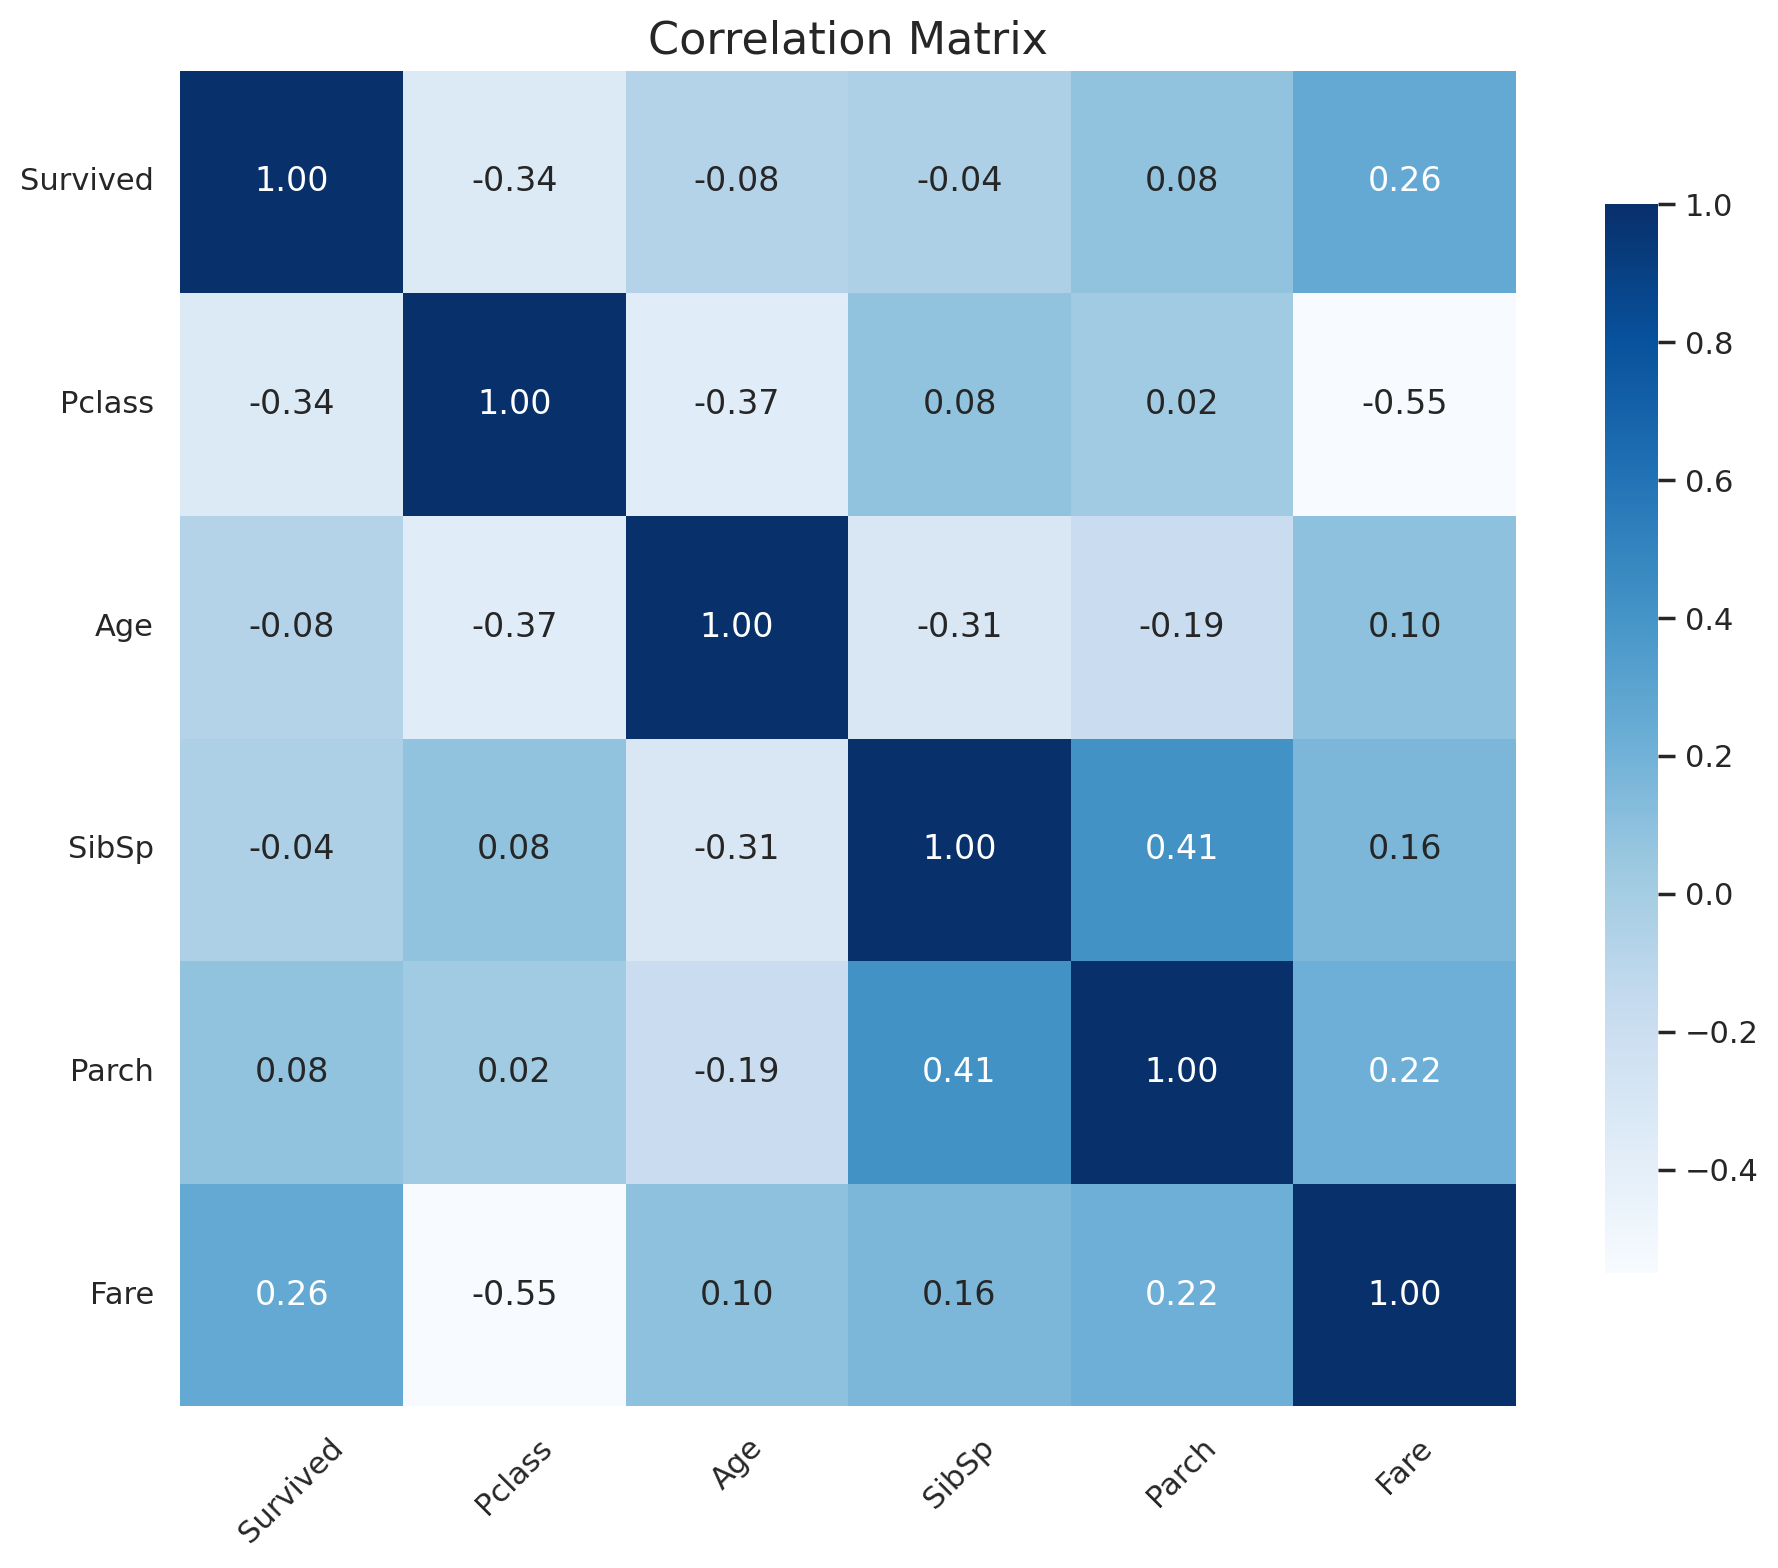

In [16]:
for i in range(len(images_list)):
    display(Image.open(os.path.join(IMAGES_DIR, images_list[i])))

## Example

In [17]:
prompt = "Generate a survival count by Gender plot and the age distribution. Use some blues colors."

In [18]:
# create a thread
thread = project_client.agents.create_thread()
print(f"Created thread, thread ID: {thread.id}")

# create a message
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

# create and execute a run
run = project_client.agents.create_and_process_run(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

if run.status == "failed":
    # Check if you got "Rate limit is exceeded.", then you want to get more quota
    print(f"Run failed: {run.last_error}")

# print the messages from the agent
messages = project_client.agents.list_messages(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_JbpV0lahr7qVXHaey5dnRtKD
Created message, message ID: msg_jf8t2PTOaCLliNciSxnIXHrA
Created run, run ID: run_l6h37hymTs8t05Y7PvJuGv65
Messages: {'object': 'list', 'data': [{'id': 'msg_4ZzmeYCAGTE9DgzaoA3EJ19T', 'object': 'thread.message', 'created_at': 1747746266, 'assistant_id': 'asst_XVqmSXT6vuAmwJHuhDbFXLEm', 'thread_id': 'thread_JbpV0lahr7qVXHaey5dnRtKD', 'run_id': 'run_l6h37hymTs8t05Y7PvJuGv65', 'role': 'assistant', 'content': [{'type': 'image_file', 'image_file': {'file_id': 'assistant-GdmRFsCWu5qKMddWe87v4p'}}, {'type': 'text', 'text': {'value': 'Here are the generated plots:\n\n1. **Survival Count by Gender**: This bar plot shows the count of passengers who survived and did not survive, separated by gender. The blue shades represent survival status (green for survival and blue for not surviving).\n\n2. **Age Distribution**: This histogram visualizes the distribution of passenger ages, with a kernel density estimate (KDE) overlay to help illustra

In [19]:
for message in messages['data']:
    for content in message['content']:
        if content['type'] == 'text':
            print(content['text']['value'])
            print('-' * 80)

Here are the generated plots:

1. **Survival Count by Gender**: This bar plot shows the count of passengers who survived and did not survive, separated by gender. The blue shades represent survival status (green for survival and blue for not surviving).

2. **Age Distribution**: This histogram visualizes the distribution of passenger ages, with a kernel density estimate (KDE) overlay to help illustrate the density of ages.

If you need any further analysis or modifications, let me know!
--------------------------------------------------------------------------------
The dataset contains 891 entries with the following relevant columns for our analysis:

- **Sex**: The gender of the passengers (male or female).
- **Survived**: Indicates whether a passenger survived (1) or not (0).
- **Age**: The ages of the passengers, with some missing values.

Next, I'll generate a survival count plot by gender and an age distribution plot using shades of blue. Let's proceed with that.
----------------

In [20]:
os.chdir(IMAGES_DIR)

images_list = []
for image_content in messages.image_contents:
    print(f"Image File ID: {image_content.image_file.file_id}")
    download_file_name = f"{image_content.image_file.file_id}_image.png"
    project_client.agents.save_file(file_id=image_content.image_file.file_id,
                                    file_name=download_file_name)
    print(f"Saved image file to: {download_file_name}")
    images_list.append(download_file_name)

os.chdir(HOME_DIR)

Image File ID: assistant-GdmRFsCWu5qKMddWe87v4p
Saved image file to: assistant-GdmRFsCWu5qKMddWe87v4p_image.png


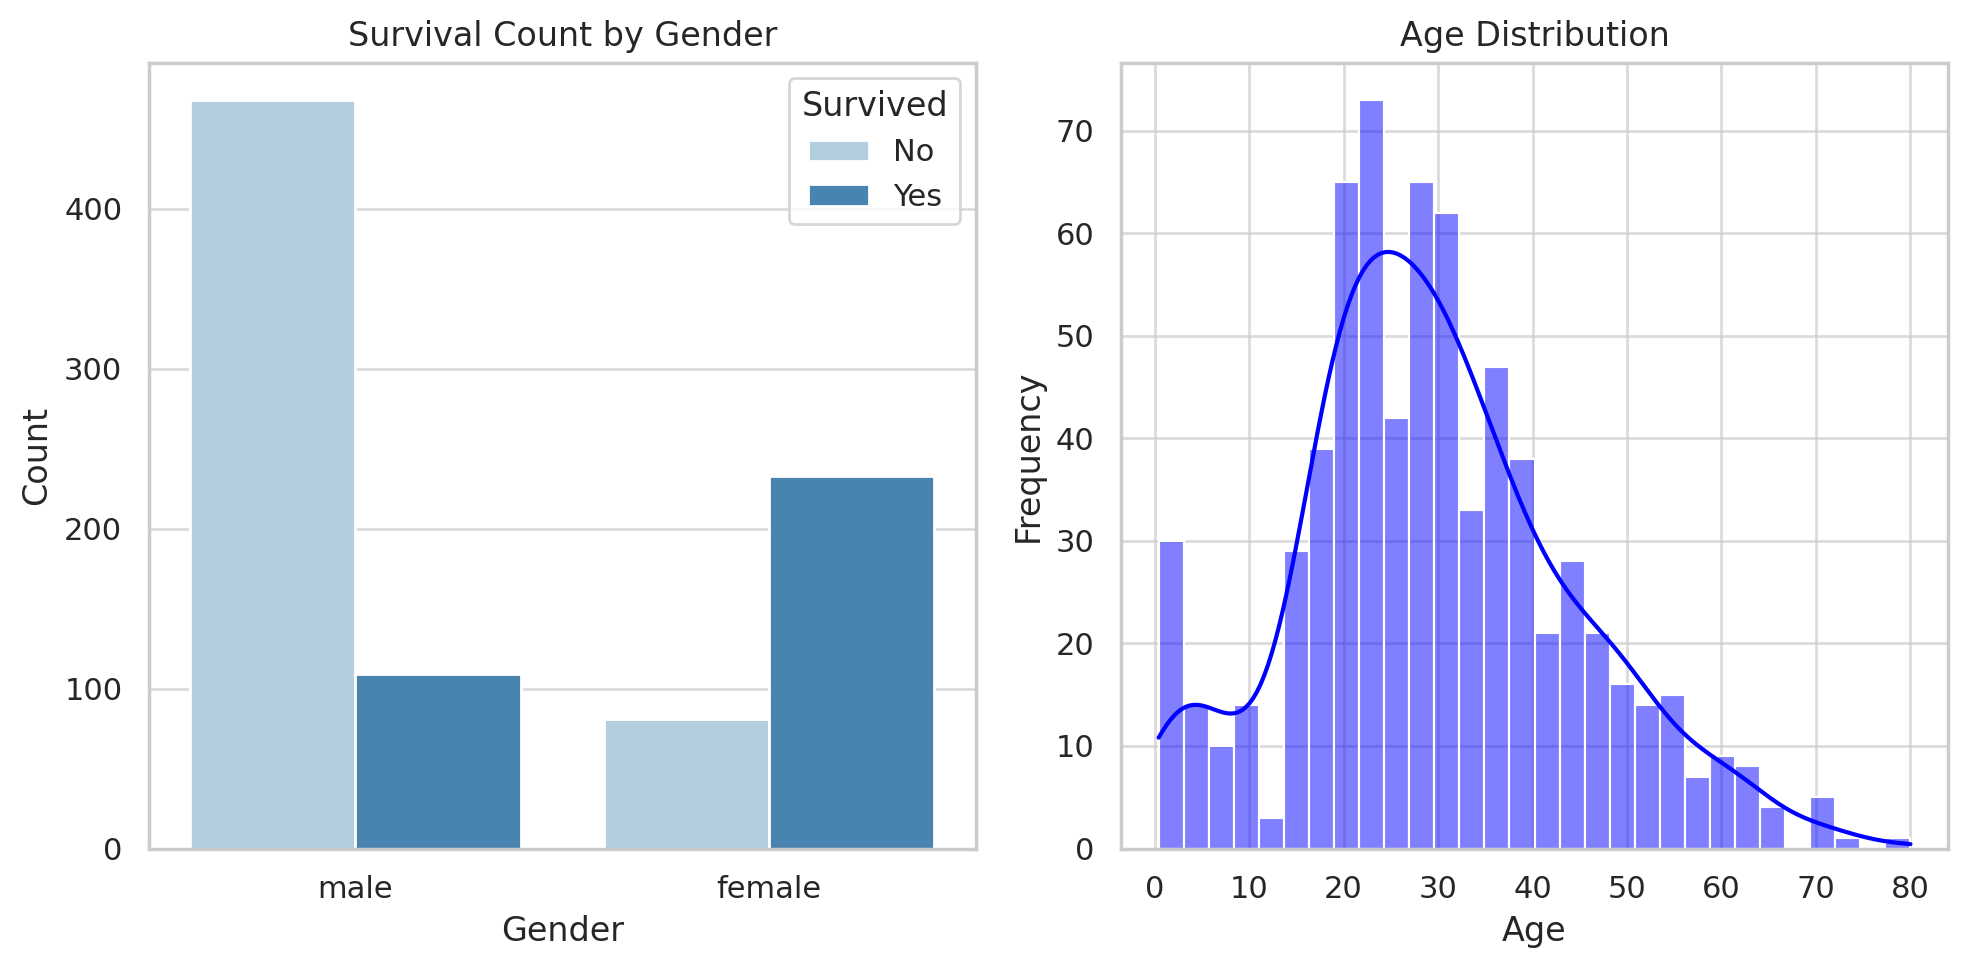

In [21]:
for i in range(len(images_list)):
    display(Image.open(os.path.join(IMAGES_DIR, images_list[i])))

## Example

In [22]:
prompt = "Generate a bivariate analysis of survival and pclass. Use some greens colors."

In [23]:
# create a thread
thread = project_client.agents.create_thread()
print(f"Created thread, thread ID: {thread.id}")

# create a message
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

# create and execute a run
run = project_client.agents.create_and_process_run(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

if run.status == "failed":
    # Check if you got "Rate limit is exceeded.", then you want to get more quota
    print(f"Run failed: {run.last_error}")

# print the messages from the agent
messages = project_client.agents.list_messages(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_S3ZxRVUkQ3wt9dRuYnvHtGQQ
Created message, message ID: msg_d1BpFi7ZaXJb9d8paUWZwNnI
Created run, run ID: run_p2ow5i2UAPX9UnOTid8BI9bX
Messages: {'object': 'list', 'data': [{'id': 'msg_dx2xpaqjAIdrBXMbKWjbOlXi', 'object': 'thread.message', 'created_at': 1747746294, 'assistant_id': 'asst_XVqmSXT6vuAmwJHuhDbFXLEm', 'thread_id': 'thread_S3ZxRVUkQ3wt9dRuYnvHtGQQ', 'run_id': 'run_p2ow5i2UAPX9UnOTid8BI9bX', 'role': 'assistant', 'content': [{'type': 'image_file', 'image_file': {'file_id': 'assistant-NxH5u8cR9GrVfzPWUtN5JK'}}, {'type': 'text', 'text': {'value': 'The bivariate analysis visualized in the plot showcases the relationship between passenger class (Pclass) and survival on the Titanic:\n\n- **Passenger Class (Pclass)** is categorized into three classes: 1st Class, 2nd Class, and 3rd Class.\n- The **Survived** variable is represented using two colors: a lighter green for passengers who did not survive and a darker green for those who did.\n\nFrom the plo

In [24]:
for message in messages['data']:
    for content in message['content']:
        if content['type'] == 'text':
            print(content['text']['value'])
            print('-' * 80)

The bivariate analysis visualized in the plot showcases the relationship between passenger class (Pclass) and survival on the Titanic:

- **Passenger Class (Pclass)** is categorized into three classes: 1st Class, 2nd Class, and 3rd Class.
- The **Survived** variable is represented using two colors: a lighter green for passengers who did not survive and a darker green for those who did.

From the plot, we can observe that:

- A higher proportion of 1st Class passengers survived compared to those in 2nd and 3rd Classes.
- 3rd Class passengers had the highest count of non-survivors.

If you require any further analysis or different visualizations, please let me know!
--------------------------------------------------------------------------------
It seems that there was an issue with using a colormap directly as a palette in the count plot. Instead, I will create a custom color palette using specific shades of green for the visualization. Let's correct this and generate the plot again.
--

In [25]:
os.chdir(IMAGES_DIR)

images_list = []
for image_content in messages.image_contents:
    print(f"Image File ID: {image_content.image_file.file_id}")
    download_file_name = f"{image_content.image_file.file_id}_image.png"
    project_client.agents.save_file(file_id=image_content.image_file.file_id,
                                    file_name=download_file_name)
    print(f"Saved image file to: {download_file_name}")
    images_list.append(download_file_name)

os.chdir(HOME_DIR)

Image File ID: assistant-NxH5u8cR9GrVfzPWUtN5JK
Saved image file to: assistant-NxH5u8cR9GrVfzPWUtN5JK_image.png


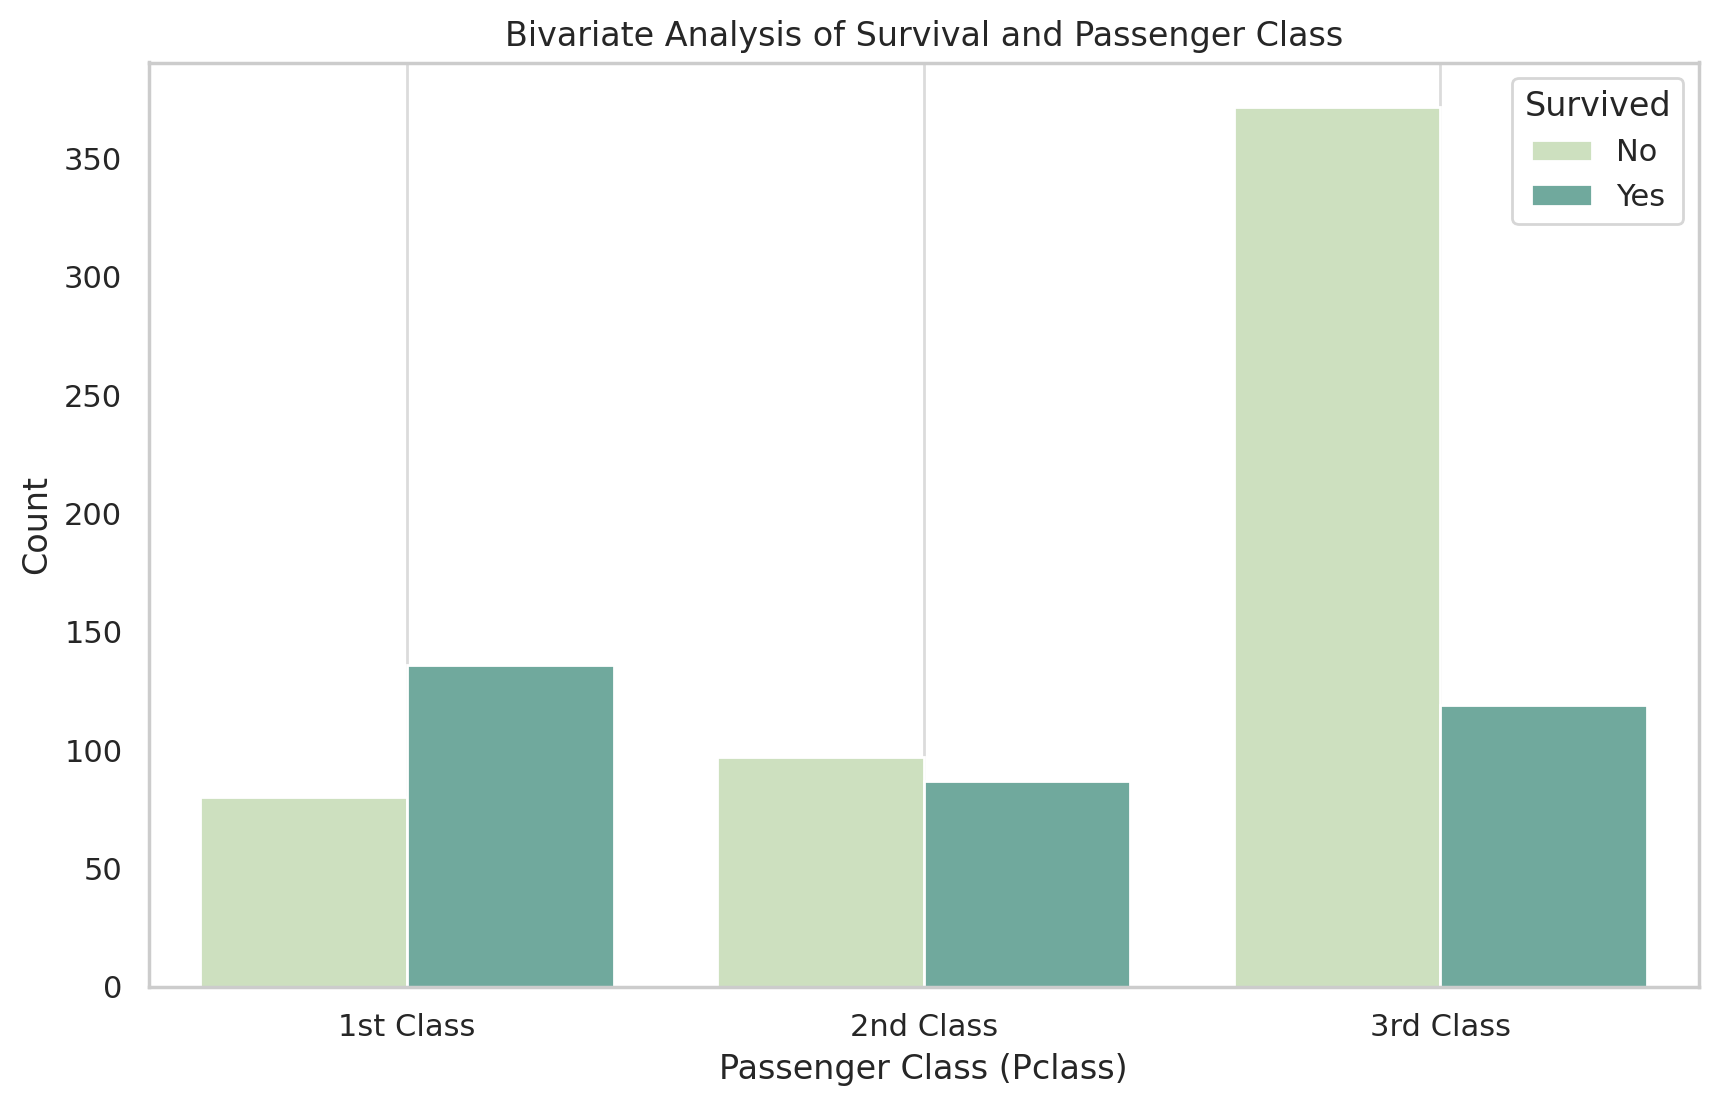

In [26]:
for i in range(len(images_list)):
    display(Image.open(os.path.join(IMAGES_DIR, images_list[i])))

## Example

In [27]:
prompt = "Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors."

In [28]:
# create a thread
thread = project_client.agents.create_thread()
print(f"Created thread, thread ID: {thread.id}")

# create a message
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

# create and execute a run
run = project_client.agents.create_and_process_run(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

if run.status == "failed":
    print(f"Run failed: {run.last_error}")

# print the messages from the agent
messages = project_client.agents.list_messages(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_7UThHupmJrgYYRK25ypGbP0y
Created message, message ID: msg_FEFAmX3vDlg2jO98vNm1pyCy
Created run, run ID: run_Z61R8Aqq6rYxY9vrb4ILV7dy
Run failed: {'code': 'server_error', 'message': 'Sorry, something went wrong.'}
Messages: {'object': 'list', 'data': [{'id': 'msg_FEFAmX3vDlg2jO98vNm1pyCy', 'object': 'thread.message', 'created_at': 1747746300, 'assistant_id': None, 'thread_id': 'thread_7UThHupmJrgYYRK25ypGbP0y', 'run_id': None, 'role': 'user', 'content': [{'type': 'text', 'text': {'value': 'Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors.', 'annotations': []}}], 'attachments': [], 'metadata': {}}], 'first_id': 'msg_FEFAmX3vDlg2jO98vNm1pyCy', 'last_id': 'msg_FEFAmX3vDlg2jO98vNm1pyCy', 'has_more': False}


In [29]:
for message in messages['data']:
    for content in message['content']:
        if content['type'] == 'text':
            print(content['text']['value'])
            print('-' * 80)

Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors.
--------------------------------------------------------------------------------


In [30]:
os.chdir(IMAGES_DIR)

images_list = []
for image_content in messages.image_contents:
    print(f"Image File ID: {image_content.image_file.file_id}")
    download_file_name = f"{image_content.image_file.file_id}_image.png"
    project_client.agents.save_file(file_id=image_content.image_file.file_id,
                                    file_name=download_file_name)
    print(f"Saved image file to: {download_file_name}")
    images_list.append(download_file_name)

os.chdir(HOME_DIR)

In [31]:
for i in range(len(images_list)):
    display(Image.open(os.path.join(IMAGES_DIR, images_list[i])))

## Example

In [32]:
prompt = "Generate the age distribution. Use lightblue color"

In [33]:
# create a thread
thread = project_client.agents.create_thread()
print(f"Created thread, thread ID: {thread.id}")

# create a message
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

# create and execute a run
run = project_client.agents.create_and_process_run(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

if run.status == "failed":
    print(f"Run failed: {run.last_error}")

# print the messages from the agent
messages = project_client.agents.list_messages(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_FCR17SlcXSbt5RwyM76GMdwp
Created message, message ID: msg_Lwb8jW0Ngi3MomtCfnbDdlfv
Created run, run ID: run_FfBHc2uqRbQMvYPDI5IaU7WB
Messages: {'object': 'list', 'data': [{'id': 'msg_HgqszHoG0ZmjsfZqoVAZ2YI6', 'object': 'thread.message', 'created_at': 1747746339, 'assistant_id': 'asst_XVqmSXT6vuAmwJHuhDbFXLEm', 'thread_id': 'thread_FCR17SlcXSbt5RwyM76GMdwp', 'run_id': 'run_FfBHc2uqRbQMvYPDI5IaU7WB', 'role': 'assistant', 'content': [{'type': 'image_file', 'image_file': {'file_id': 'assistant-JUq1diCSCETaojCStWcD22'}}, {'type': 'text', 'text': {'value': 'Here is the age distribution of the passengers represented in a histogram. The bars are colored light blue, and the distribution shows how many passengers fall into different age ranges.\n\nIf you need any further analysis or a different representation, feel free to ask!', 'annotations': []}}], 'attachments': [], 'metadata': {}}, {'id': 'msg_To3CbuEOO1ytwlNdVyp6GJuS', 'object': 'thread.message', 'created

In [34]:
for message in messages['data']:
    for content in message['content']:
        if content['type'] == 'text':
            print(content['text']['value'])
            print('-' * 80)

Here is the age distribution of the passengers represented in a histogram. The bars are colored light blue, and the distribution shows how many passengers fall into different age ranges.

If you need any further analysis or a different representation, feel free to ask!
--------------------------------------------------------------------------------
The uploaded file appears to be a dataset related to passengers, likely from a model like the Titanic dataset. It contains several columns, including:

- `PassengerId`: Unique identifier for each passenger
- `Survived`: Survival status (0 = No, 1 = Yes)
- `Pclass`: Passenger Class
- `Name`: Name of the passenger
- `Sex`: Gender of the passenger
- `Age`: Age of the passenger
- `SibSp`: Number of siblings/spouses aboard
- `Parch`: Number of parents/children aboard
- `Ticket`: Ticket number
- `Fare`: Ticket fare
- `Cabin`: Cabin number
- `Embarked`: Port of embarkation

To generate the age distribution, I will focus on the `Age` column. Let's c

In [35]:
os.chdir(IMAGES_DIR)

images_list = []
for image_content in messages.image_contents:
    print(f"Image File ID: {image_content.image_file.file_id}")
    download_file_name = f"{image_content.image_file.file_id}_image.png"
    project_client.agents.save_file(file_id=image_content.image_file.file_id,
                                    file_name=download_file_name)
    print(f"Saved image file to: {download_file_name}")
    images_list.append(download_file_name)

os.chdir(HOME_DIR)

Image File ID: assistant-JUq1diCSCETaojCStWcD22
Saved image file to: assistant-JUq1diCSCETaojCStWcD22_image.png


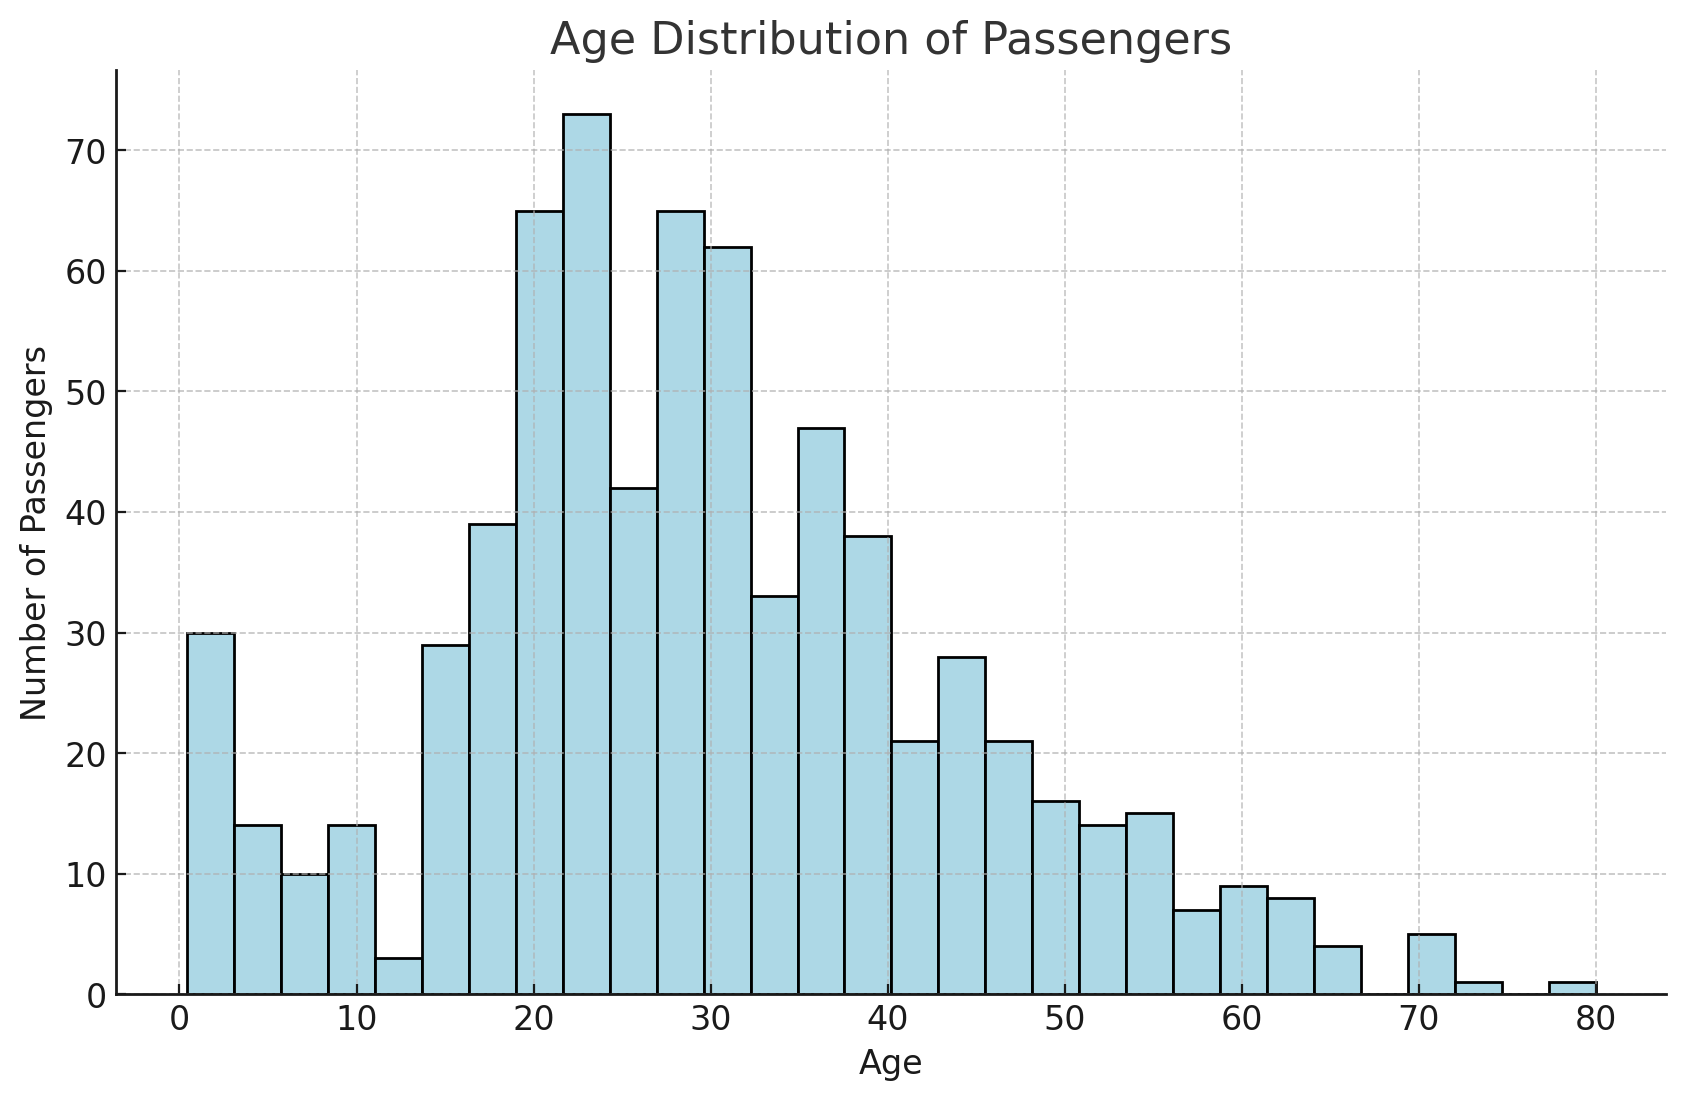

In [36]:
for i in range(len(images_list)):
    display(Image.open(os.path.join(IMAGES_DIR, images_list[i])))

## All images

In [37]:
def multiple_images(images_list, num_cols=4):
    """
    Display multiple images
    """
    num_rows = int(len(images_list) / num_cols) + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(images_list):
            image = plt.imread(images_list[idx])
            ax.imshow(image)
            ax.axis('off')

        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


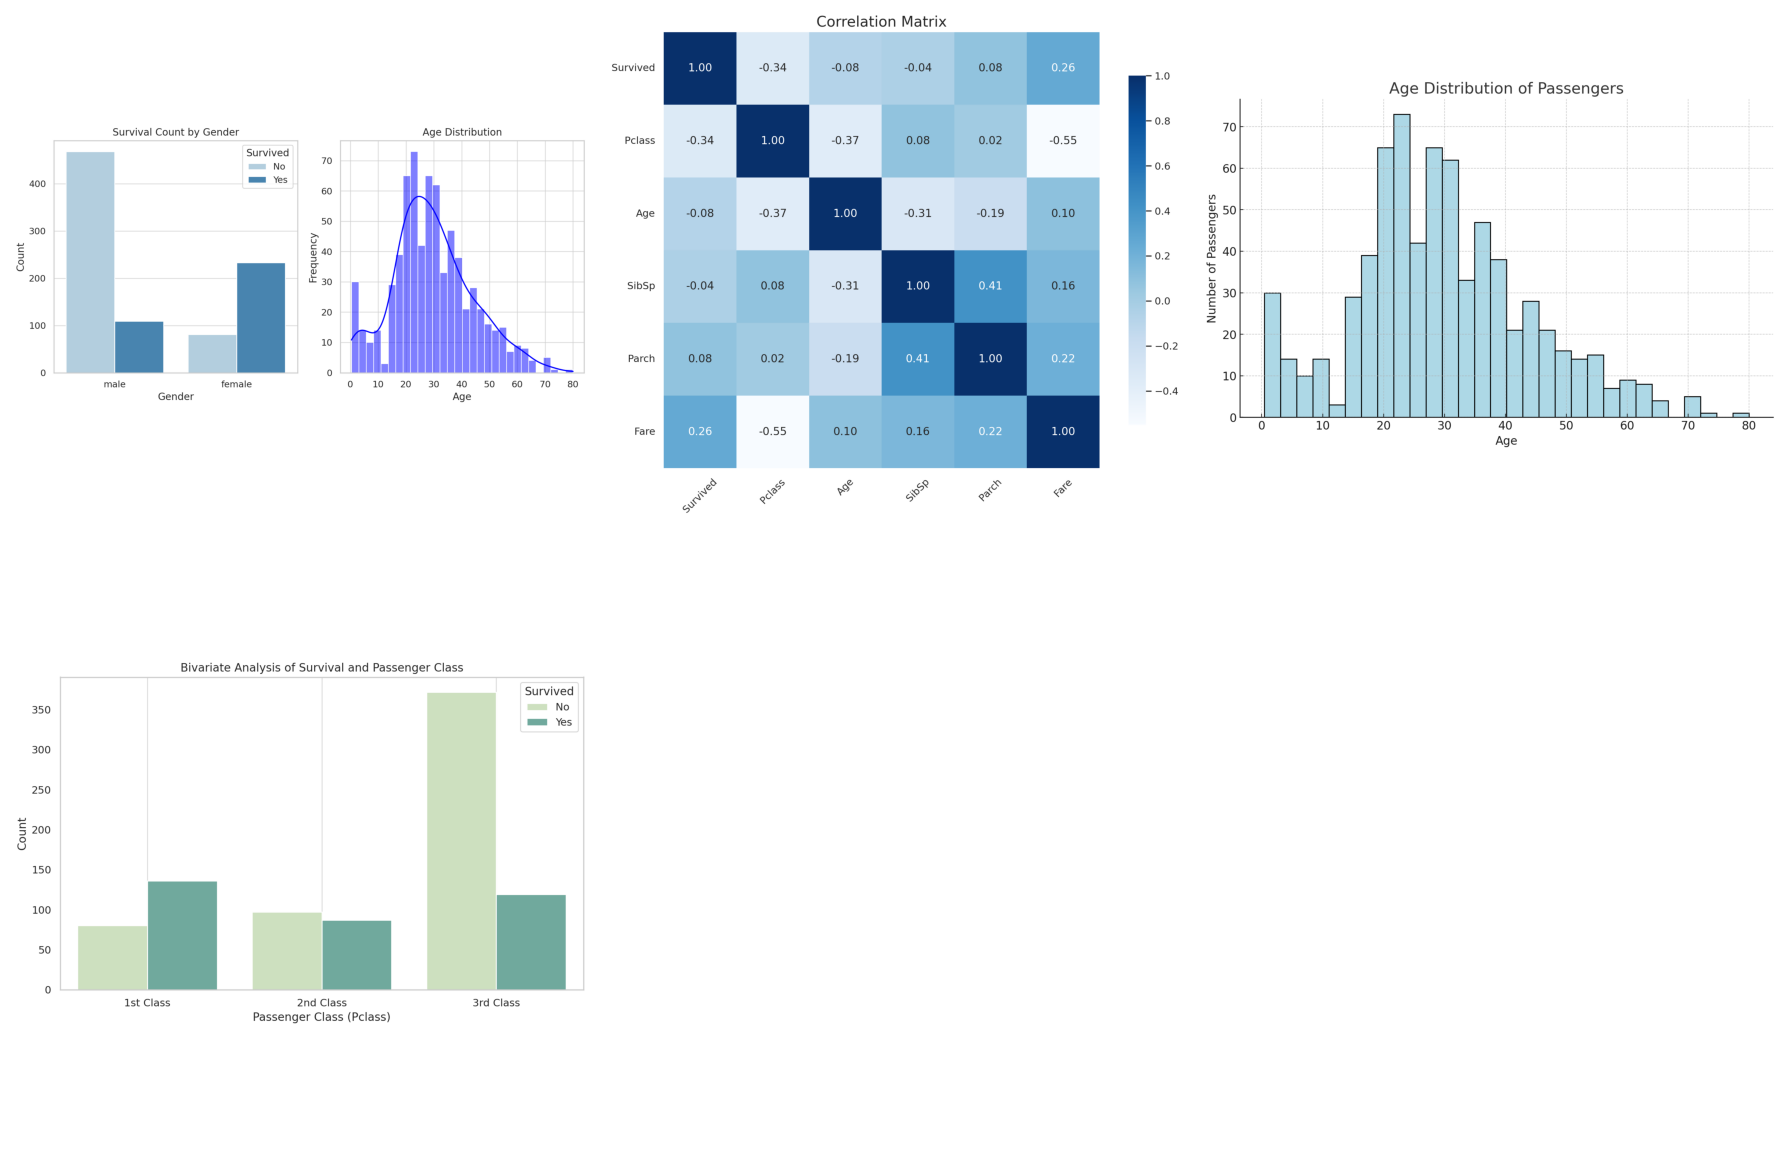

In [38]:
images_list = glob.glob(IMAGES_DIR +  '/*.png')

multiple_images(images_list, num_cols=3)

## Cleaning

In [39]:
for filename in os.listdir(IMAGES_DIR):
    if filename.endswith(".png"):
        image_file = os.path.join(IMAGES_DIR, filename)
        print(f"Deleting image file {image_file}")
        os.remove(image_file)

Deleting image file images/assistant-GdmRFsCWu5qKMddWe87v4p_image.png
Deleting image file images/assistant-GKTVdMaTYnfpAJuTgi118C_image.png
Deleting image file images/assistant-JUq1diCSCETaojCStWcD22_image.png
Deleting image file images/assistant-NxH5u8cR9GrVfzPWUtN5JK_image.png


In [40]:
# delete the original file from the agent to free up space
print("Deleted file")
project_client.agents.delete_file(file.id)
print("Done")

Deleted file
Done


In [41]:
project_client.agents.delete_agent(agent.id)

{'id': 'asst_XVqmSXT6vuAmwJHuhDbFXLEm', 'object': 'assistant.deleted', 'deleted': True}